## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
!nvidia-smi

Mon Aug  5 15:55:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |   2584MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pwd

'/content'

In [4]:
cd /content/drive/My \Drive/Colab \Notebooks

/content/drive/My Drive/Colab Notebooks


In [5]:
from keras.datasets import cifar10
from keras.applications import VGG16 
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

Using TensorFlow backend.


In [6]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
# 建立VGG16模型
conv_vgg = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (32, 32, 3))
conv_vgg.summary()


W0805 15:56:53.292464 140007923677056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 15:56:53.313860 140007923677056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 15:56:53.318770 140007923677056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 15:56:53.345170 140007923677056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0805 15:56:53.653257 140007923677056 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

### Feature Extraction with Data Augmentation

In [0]:
batch_size = 64 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 30 # 訓練整個資料集共 30個循環


In [9]:
model = Sequential()
model.add(conv_vgg)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
________________________________________________________________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [0]:
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1 / 255)
train_datagen.fit(x_train)

In [14]:
model.compile( loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size = batch_size),
    steps_per_epoch = len(x_train)/ batch_size,
    verbose = 1,
    epochs = epochs,
    validation_data = test_datagen.flow(x_test, y_test, batch_size = batch_size),
    validation_steps = 50
)
score = model.evaluate(x_test/255, y_test, verbose = 0)
print('Test loss', score[0])
print('Test accuracy', score[1])

W0805 16:06:52.844693 140007923677056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
782/781 [==============================] - 42s 54ms/step - loss: 1.9086 - acc: 0.2312 - val_loss: 1.9180 - val_acc: 0.2975
Epoch 2/30
782/781 [==============================] - 37s 47ms/step - loss: 1.5184 - acc: 0.4089 - val_loss: 1.2385 - val_acc: 0.5509
Epoch 3/30
782/781 [==============================] - 37s 47ms/step - loss: 1.2400 - acc: 0.5524 - val_loss: 1.1782 - val_acc: 0.6172
Epoch 4/30
782/781 [==============================] - 37s 47ms/step - loss: 1.0926 - acc: 0.6161 - val_loss: 0.9610 - val_acc: 0.6783
Epoch 5/30
782/781 [==============================] - 37s 47ms/step - loss: 1.0047 - acc: 0.6527 - val_loss: 1.0425 - val_acc: 0.6722
Epoch 6/30
782/781 [==============================] - 37s 47ms/step - loss: 0.9396 - acc: 0.6838 - val_loss: 1.1260 - val_acc: 0.6637
Epoch 7/30
782/781 [==============================] - 37s 47ms/step - loss: 0.8866 - acc: 0.7011 - val_loss: 0.7286 - val_acc: 0.7643
Epoch 8/30
782/781 [==============================] - 37s 47ms

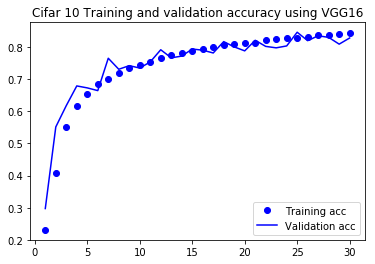

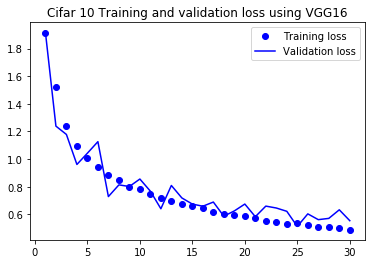

In [17]:
# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Cifar 10 Training and validation accuracy using VGG16')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Cifar 10 Training and validation loss using VGG16')
plt.legend()
plt.show()